### Baseline Text Data Augmentation Methods

Compare and supplement advanced method with baseline traditional (easy to implement methods).


### Prepare Environment

In [1]:
import random
from numpy.random import seed
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np
seed(156)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [4]:
# Install required nltk resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Importing required libraries
import pandas as pd
from tqdm.std import tqdm
from IPython.display import display, HTML
from nltk.corpus import wordnet
import time
import re

### Load Data

In [6]:
# Let's start with the **hydraulic fluid or oil leak** dataset.
focus = 'hydraulic fluid or oil leak'
sample_name = 'df_train_trues' #dataset_names[0]
reports = pd.read_csv(f"data/prepared/{sample_name}.csv", dtype=str)  

In [7]:
# Remove unecessary columns.
reports = reports[['text', 'category']]
reports

,text,category
0,robodrill spider excavator being operated when...,1
1,fuel red diesel spilled onto whiterockdirt sur...,1
2,oil leak from crane that was on site for plann...,1
3,small oil spill on twenty-one thousand and twe...,1
4,spider excavator hyd leak to soil 10ml spider ...,1
...,...,...
465,struck by discharged object or substance an em...,1
466,injured by slipping or swinging object held by...,1
467,struck by swinging part of powered vehicle an ...,1
468,caught in running equipment or machinery durin...,1


### Simple Text Augmentation Techniques

Jason W Wei and Kai Zou. 2019. Eda: Easy data augmentation techniques for boosting perfor- mance on text classification tasks. arXiv preprint arXiv:1901.11196.

- Synonym Replacement (SR)
- Random Deletion (RD)
- Random Swap (RS)
- Random Insertion (RI)

In [15]:
# Modifications Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: CC-BY-NC-4.0
# Original Copyright https://github.com/jasonwei20/eda_nlp

# stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our',
              'ours', 'ourselves', 'you', 'your', 'yours',
              'yourself', 'yourselves', 'he', 'him', 'his',
              'himself', 'she', 'her', 'hers', 'herself',
              'it', 'its', 'itself', 'they', 'them', 'their',
              'theirs', 'themselves', 'what', 'which', 'who',
              'whom', 'this', 'that', 'these', 'those', 'am',
              'is', 'are', 'was', 'were', 'be', 'been', 'being',
              'have', 'has', 'had', 'having', 'do', 'does', 'did',
              'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
              'because', 'as', 'until', 'while', 'of', 'at',
              'by', 'for', 'with', 'about', 'against', 'between',
              'into', 'through', 'during', 'before', 'after',
              'above', 'below', 'to', 'from', 'up', 'down', 'in',
              'out', 'on', 'off', 'over', 'under', 'again',
              'further', 'then', 'once', 'here', 'there', 'when',
              'where', 'why', 'how', 'all', 'any', 'both', 'each',
              'few', 'more', 'most', 'other', 'some', 'such', 'no',
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too',
              'very', 's', 't', 'can', 'will', 'just', 'don',
              'should', 'now', '']

def get_only_chars(line):
    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ")  # replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +', ' ', clean_line)  # delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line



# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            # print("replaced", random_word, "with", synonym)
            num_replaced += 1
        if num_replaced >= n:  # only replace up to n words
            break

    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return new_words


def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)



# Random deletion
# Randomly delete words from the sentence with probability p
def random_deletion(words, p):
    # obviously, if there's only one word, don't delete it
    if len(words) == 1:
        return words

    # randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    # if you end up deleting all words, just return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words) - 1)
        return [words[rand_int]]

    return new_words


# Random swap
# Randomly swap two words in the sentence n times
def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words


def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words) - 1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words) - 1)
        counter += 1
        if counter > 3:
            return new_words
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
    return new_words


# Random insertion
# Randomly insert n words into the sentence
def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words


def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words) - 1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words) - 1)
    new_words.insert(random_idx, random_synonym)



# main data augmentation function
def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
    sentence = get_only_chars(sentence)
    words = sentence.split(' ')
    words = [word for word in words if word is not '']
    num_words = len(words)

    augmented_sentences = []
    num_new_per_technique = int(num_aug / 4) + 1
    n_sr = max(1, int(alpha_sr * num_words))
    n_ri = max(1, int(alpha_ri * num_words))
    n_rs = max(1, int(alpha_rs * num_words))

    # synonym replacement
    for _ in range(num_new_per_technique):
        a_words = synonym_replacement(words, n_sr)
        augmented_sentences.append(' '.join(a_words))

    # random insertion
    for _ in range(num_new_per_technique):
        a_words = random_insertion(words, n_ri)
        augmented_sentences.append(' '.join(a_words))

    # randown swap
    for _ in range(num_new_per_technique):
        a_words = random_swap(words, n_rs)
        augmented_sentences.append(' '.join(a_words))

    # random deletion
    for _ in range(num_new_per_technique):
        a_words = random_deletion(words, p_rd)
        augmented_sentences.append(' '.join(a_words))

    augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
    shuffle(augmented_sentences)

    # trim so that we have the desired number of augmented sentences
    if num_aug >= 1:
        augmented_sentences = augmented_sentences[:num_aug]
    else:
        keep_prob = num_aug / len(augmented_sentences)
        augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

    return augmented_sentences

In [16]:
def gen_eda(in_df, alpha, num_aug=1):

    #in_df.reset_index(inplace=True)
    lines = in_df.text
    labels = in_df.category
    out_sens = []
    
    for i, line in tqdm(enumerate(lines)):        
        label = int(labels[i])
        if label == 1:
            sentence = line
            aug_sentence = eda(sentence, alpha_sr=alpha, alpha_ri=alpha, alpha_rs=alpha, p_rd=alpha, num_aug=num_aug)
            out_sens.extend(aug_sentence)

    out_df = pd.DataFrame(out_sens, columns = ['text'])    
    out_df['category'] = 1
    return(out_df)

### Perfrom Data Augmentation

In [17]:
# Printing long descriptions in Colab can be messy as they don't wrap
# Create simple function to split lines to set length
def split_input(user_string, chunk_size):
    output = []
    words = user_string.split(" ")
    total_length = 0

    while (total_length < len(user_string) and len(words) > 0):
        line = []
        next_word = words[0]
        line_len = len(next_word) + 1

        while (line_len < chunk_size) and len(words) > 0:
            words.pop(0)
            line.append(next_word)

            if (len(words) > 0):
                next_word = words[0]
                line_len += len(next_word) + 1

        line = " ".join(line)
        output.append(line)
        total_length += len(line) 

    print('\n')
    for chunk in output: 
        print(chunk)

In [18]:
# Generate data for augmentation
df_eda = gen_eda(reports, alpha = 0.1, num_aug=10)

# Compare augmented to original (for first narrative)
# to visually inspect augmentation
split_input(reports.text[0], 80)
split_input(df_eda.text.iloc[0], 80)

470it [00:03, 130.72it/s]



robodrill spider excavator being operated when hose fitting failed and
released 20ml of hyd fluid to grade at approximately one thousand and fifteen
on the 27th of feb a hydraulic hose fitting failed and released 20ml of hyd
fluid to grade on the robodrill spider excavator at kp64 on the row all
contaminated materials absorbent pads were disposed of appropriately into the
contaminated waste bags


absorbent spider excavator being operated a failed fitting failed and released
ml of hyd fluid to grade at approximately one thousand and fifteen on the th
of feb robodrill hydraulic hose fitting hose and released ml of hyd the to
grade on the robodrill spider excavator at kp on fluid row all contaminated
materials appropriately pads were disposed of when into the contaminated waste
bags


In [12]:
# Now visually inspect a random sample of 20
table = df_eda.sample(20)
display(HTML(table.to_html()))

,text,category
3035,swp crane hydraulic oil leak around one thousand four hundred while about to lift a container from the vessel lewek hydra one of the personnel working on wearther deck noticed an dripping from the operators cab he immediately informed the swp deck crew about the oil dripping deck crew immediately signaled stop the operation and park the on the crane boom rest for investigation upon checking it was found that one of the hose twenty two hundred and seventy four deck crew immediately signaled the crane operator to stop operation and park the crane boom to the crane rest a bucket was used to the dripping hydraulic oil the deck crew at the same time cleaned up oil spill that on deck floor the incident was reported to the field maintenance supervisor,1
530,residual hydraulic oil from underneath the the engine dripped the the ground during heavy rainfall the oily sheen was off up ground the not enter any water course was the water will owned pick up truck was driven by wood secondee staff the vehicle was parked on the road between ler bioversal contacted the process cordoned during heavy rainfall other wood course noticed an oily sheen on the and and or the she will area tech to alert them of a spill the vehicle had recently been for service treat it is suspected that onto oil remained on residual splash guard which was spread by the heavy rain fallthe area was area cleaned and purpose spill mats were used to clean up the spill but were not effective one drain used to and the spill and it was purposefully washed into did vdrain in a controlled manner where it was collected by the waste contractor at the time there was heavy rainfall combined this was the best option to ensure vehicle oily water did not enter any incident and she see personnel detailed description,1
1219,a leak was found at crude oil storage a cost during area checks at am on the th december thousand sixteen rate estimated at litresminute incident the leak was found during routine area checks at am on the december two thousand and sixteen the last checks had been carried at am on the th and nothing untoward was latest estimate of flow is approximately l per minute analysis carried out on this fluid suggests the release is that the crude that is stored in cost a this is currently flowing to the gully the base of the a and being captured within the contaminated drains system this is routed to ballast tank a until required equipment is available to circulate the released oil back to cost athe manufacturers have been contacted to ascertain the likely source of the leak which could be either the tank or the ring on reporting this to health and safety executive it was relayed that a similar release in another location resulted in a failure the tank on receiving information from tank manufacturer will be better understood the the of the tank and should additional pollution response be required wood group shall inform the external respondersarrangements are currently being made to have the tank contents removedupdate discharge cost a completed on three hundred and thousand two hundred and sixteen to tanker see detailed description,1
3964,exposure to harmful substances or environments unspecified an line was hospitalization the hydraulic line resulting a bucket truck when the employee ruptured his face was splashed with hydraulic fluid on in facial burns and repairing,1
4173,struck eject by discharged object unstable or substance an employee was untangling a crimped hydraulic line and hydraulic fluid was injected into the employee hand,1
1393,oil leaksspill ten a spillleaks incident approximately one thousand and mechanicscommenced am operator was pushing the gravel back and forth to level excavation ramps a on a slope sketch valveand absorbent hilltop at well traysto f he noticed dozer blade malfunctioning resulting from range worn outtear outbroken hydraulic hosemain control valve causing hydraulic oil dozer approx ml he stopped and immediately placed up 

In [13]:
# Check the the number of fake narrratives (should be n x unique prompt count)
rep_count = len(df_eda)
print('No. of fabricated reports: ', rep_count)

# Now write the fake data to the 'fabricated' subfolder of the data folder
# This data will be used for transformer-based data augmentation (TrDA)
df_eda.to_csv(f'data/fabricated/{focus}_{rep_count}_simple_da.csv', index=False)

No. of fabricated reports:  4700


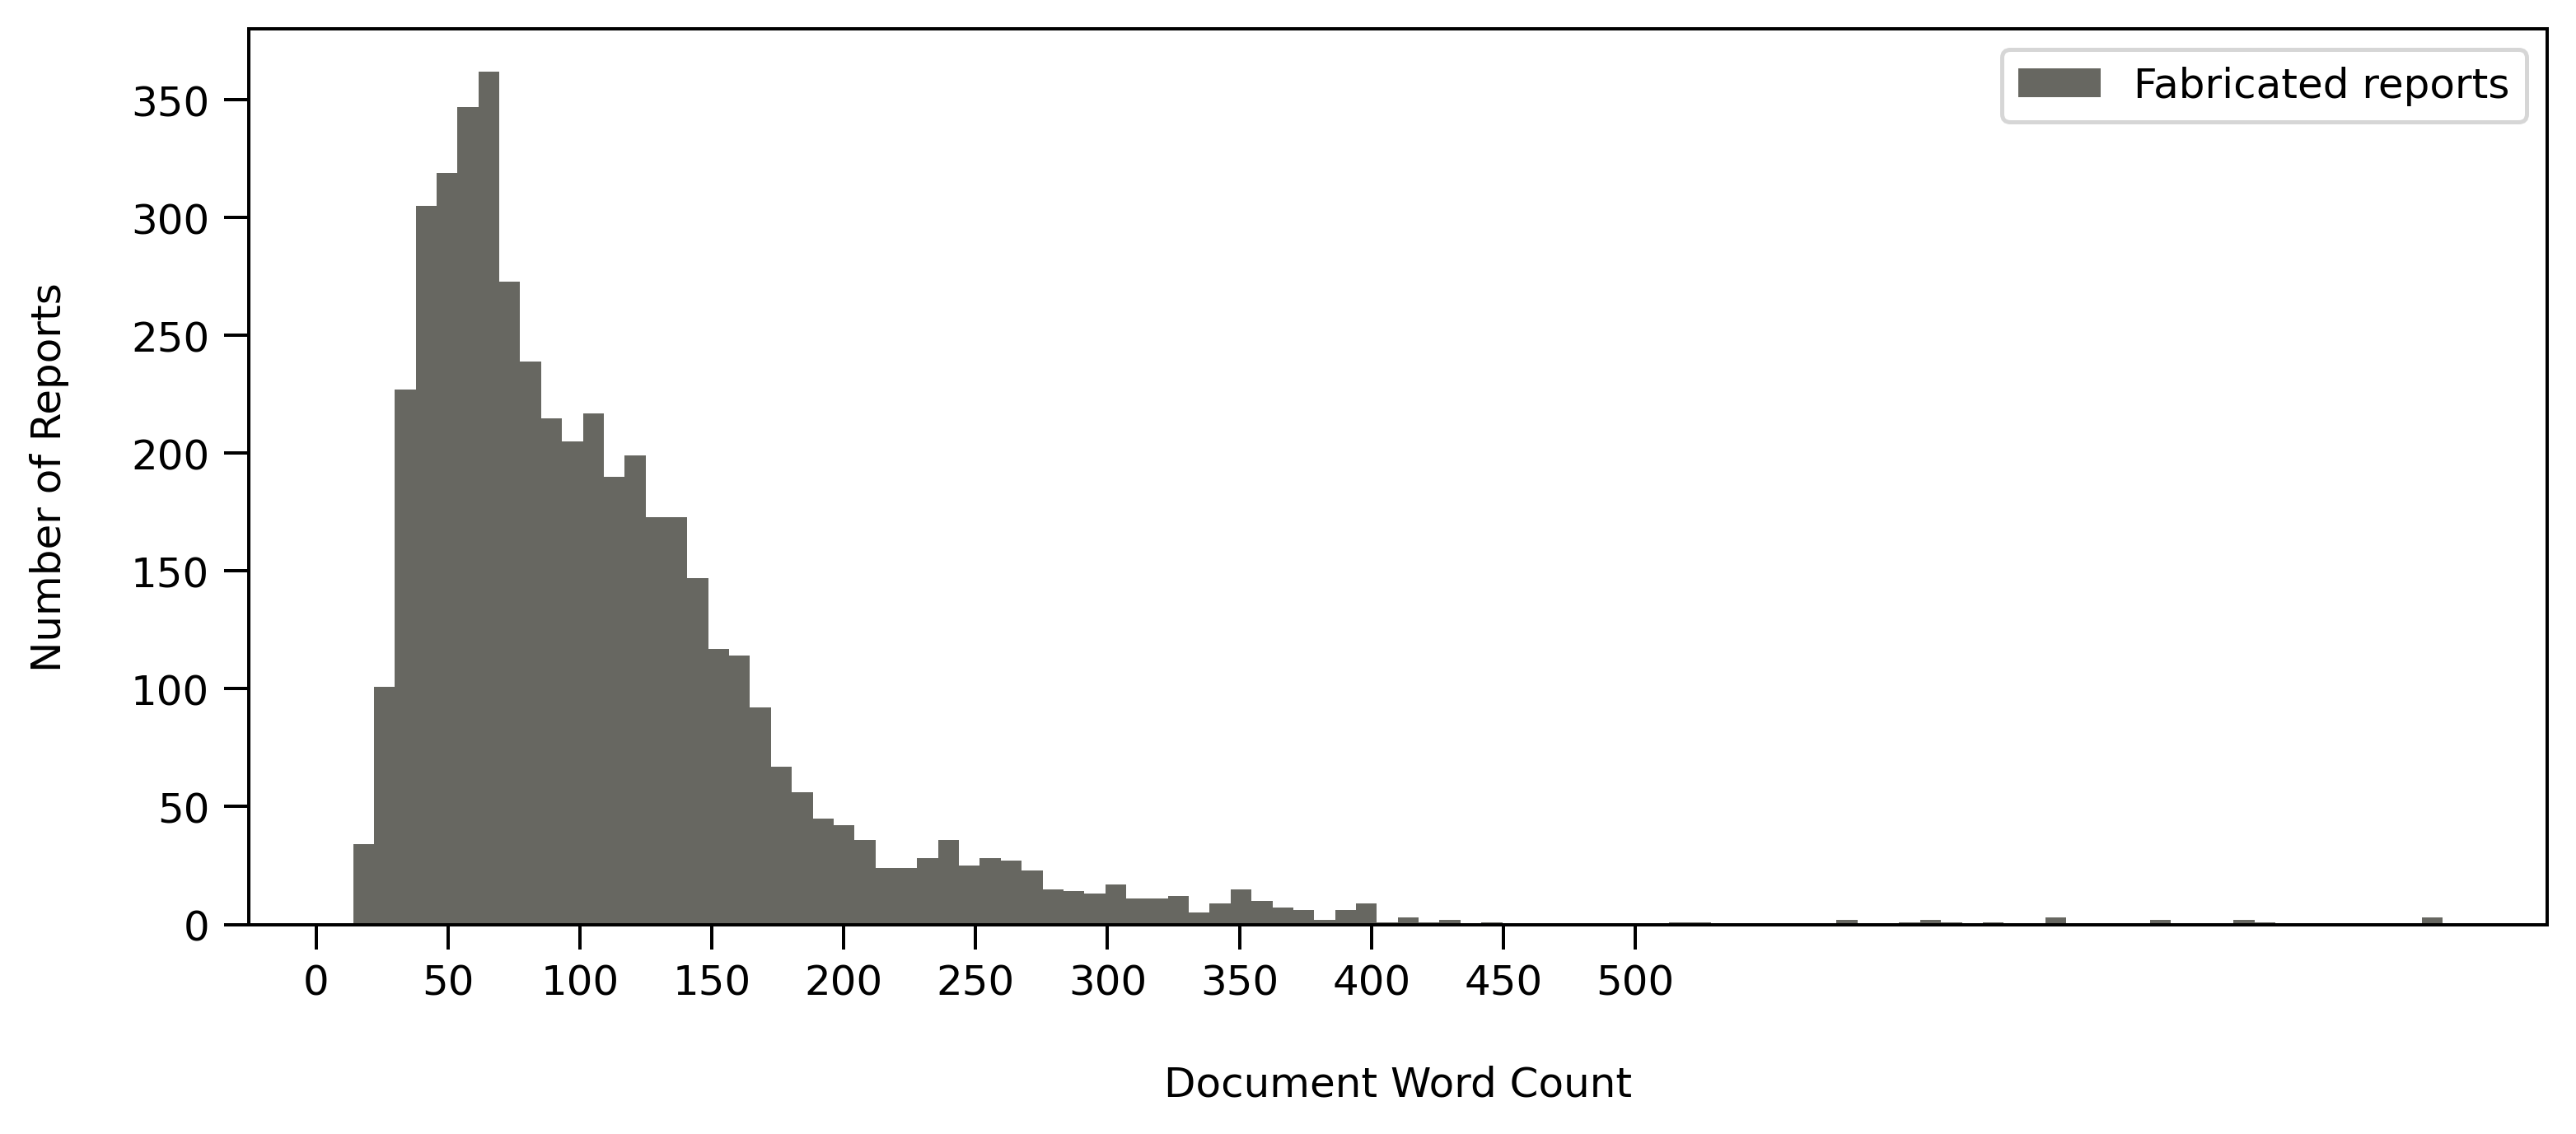

In [14]:
# Plot a histogram of word counts in the fake narratives
# Remember the real raw data has a mean word count of 62 and 95 percentile value of 309 words
# We expect to see similar distribution for the fake narratives...
doc_lens = [len(d.split()) for d in df_eda.text]
plt.figure(figsize=(10, 4), dpi=360)
plt.hist(doc_lens, bins = 100, color='#26261e', alpha=0.7, label = 'Fabricated reports')
plt.legend(loc = 'upper right')

plt.xlabel("Document Word Count", labelpad = 15)
plt.ylabel("Number of Reports", labelpad = 15)
plt.tick_params(size=6)
plt.xticks(np.linspace(0, 500, 11))
plt.title('', fontdict=dict(size=10))
plt.show()